# Zapien Difficulty‑Prediction Pipeline

This notebook implements an end-to-end pipeline for predicting question difficulty in educational assessments using Item Response Theory (IRT) and neural networks.

## Overview

The pipeline follows these main steps:
1. Calculate empirical difficulty of questions using 1-PL IRT modeling
2. Extract features from question text and multiple-choice options
3. Generate text embeddings for questions and options
4. Train a neural network to predict student performance
5. Evaluate the model on hold-out data
6. Compare predicted difficulty with empirical difficulty estimates

All orchestration lives **inside this notebook**; module files expose only
small helpers. By scrolling top‑to‑bottom you will see every data
transformation step.


## 1 Setup

### 1.1 Load libraries and modules

The pipeline uses several custom modules for different stages of processing:
- `irt`: Item Response Theory modeling for calculating question difficulty
- `features`: Feature extraction from question text and options
- `embeddings`: Text embedding generation using pretrained models
- `utils`: Helper functions for text formatting and preprocessing
- `modeling_data`: Dataset preparation for neural network training
- `neural_net`: Neural network architecture and training functions
- `evaluation`: Model evaluation and metric calculation

In [1]:
# Standard Python libraries
import os
import pickle
import pandas as pd
from datetime import datetime
from collections import defaultdict

# --- External pipeline modules ---
# IRT difficulty estimation
from modules.irt import estimate_irt_2pl_params

# Feature extraction
from modules.features import extract_text_features, calculate_option_features
from modules.embeddings import generate_text_embeddings
from modules.utils import format_question_text

# Data preparation and model training
from modules.modeling_data import (
    stratified_question_split_3way,
    prepare_nn_datasets,
    save_preprocessors,
)
from modules.neural_net import create_nn_model, train_nn_model, save_nn_model

# Evaluation
from modules.evaluation import (
    make_dataset,
    evaluate_model,
    dump_json,
    prediction_matrix,
    difficulty_from_predictions,
    compare_difficulty,
)

### 1.2 Define constants

These constants define column names, model parameters, and configuration settings used throughout the pipeline.

In [2]:
# CELL TO UPDATE in main.ipynb (Section 1.2 Define constants)

# --- Core column names for student response data ---
USER_ID_COL = "user_id"              # Identifier for students/users
QUESTION_ID_COL = "question_id"      # Identifier for questions
CORRECTNESS_COL = "is_correct"       # Binary indicator of response correctness

# --- Question content columns ---
QUESTION_TEXT_COL = "question_title"  # Text of the question prompt
OPTION_COLS = ["option_a", "option_b", "option_c", "option_d", "option_e"]  # Multiple choice options
CORRECT_OPTION_COL = "correct_option_letter"  # Letter of the correct option (A-E)
FORMATTED_TEXT_COL = "formatted_question_text"  # Processed question text
IRT_DIFFICULTY_COL = "difficulty"  # IRT-based difficulty parameter

# --- Embedding model configuration ---
EMBEDDING_MODEL = "nomic-ai/modernbert-embed-base"  # Text embedding model
EMBEDDING_BATCH_SIZE = 32  # Batch size for generating embeddings

# --- Dataset split configuration ---
TEST_SPLIT_SIZE = 0.1     # Proportion of data for final evaluation
VALIDATION_SPLIT_SIZE = 0.2  # Proportion of data for validation during training
RANDOM_SEED = 42          # Seed for reproducibility

# --- Numerical features for neural network input ---
# These features capture various aspects of question complexity and structure
NUMERICAL_FEATURE_COLS = [
    # Text complexity metrics (existing)
    "question_word_count", "question_char_count", "question_avg_word_length",
    "question_digit_count", "question_special_char_count",
    "question_mathematical_symbols", "question_latex_expressions",

    # Option-related metrics (existing)
    "jaccard_similarity_std", "avg_option_length", "avg_option_word_count",

    # Pedagogical metadata (existing - some might overlap or be refined by new features)
    "avg_steps", "level", "num_misconceptions", "has_image", # Keep existing for now

    # --- NEW: Add new numerical and binary features ---
    "Answer_Length_Variance",
    "Correct_Distractor_CosineSim_Mean",
    "Distractor_Embedding_Distance_Mean",
    "Extreme_Wording_Option_Count",
    "Has_Abstract_Symbols", # Binary, treated as numerical
    "Has_NoneAll_Option",   # Binary, treated as numerical
    "LLM_Distractor_Plausibility_Max",
    "LLM_Distractor_Plausibility_Mean",
    "Mathematical_Notation_Density",
    "Max_Expression_Nesting_Depth",
    "Option_Length_Outlier_Flag", # Binary, treated as numerical
    "Question_Answer_Info_Gap",
    "Ratio_Abstract_Concrete_Symbols",
    "RealWorld_Context_Flag",     # Binary, treated as numerical
    "Units_Check"                 # Binary, treated as numerical
]

# --- NEW: Define categorical features to be one-hot encoded ---
CATEGORICAL_FEATURE_COLS_TO_ENCODE = [
    "Knowledge_Dimension",
    "Most_Complex_Number_Type", # Even though it's int, it's categorical
    "Problem_Archetype"
]

# Note: The one-hot encoded columns will be added to the final list of numerical features
# by the prepare_nn_datasets function.

### 1.3 Define paths

Set up file paths for data input/output and create a timestamped directory for results.

In [3]:
# --- Path configuration ---
# Root directory is one level up from current working directory
ROOT_DIR = os.path.abspath(os.path.dirname(os.getcwd()))

# Input data location
DATA_DIR = "data/zapien"
ANSWERS_FILE_PATH = os.path.join(ROOT_DIR, DATA_DIR, "answers.csv")
QUESTIONS_FILE_PATH = os.path.join(ROOT_DIR, DATA_DIR, "questions.csv")
ADDITIONAL_FEATURES_FILE_PATH = os.path.join(ROOT_DIR, DATA_DIR, "questions_additional_features.csv")

# Output directory for results
RESULTS_DIR = os.path.join(ROOT_DIR, "results")

# Create a timestamped directory for this run's outputs
current_run_dir = os.path.join(RESULTS_DIR, datetime.now().strftime("%Y%m%d_%H%M%S"))
os.makedirs(current_run_dir, exist_ok=True)
print("Results will be saved to:", current_run_dir)

Results will be saved to: /Users/matias/Projects/capstone-new/results/20250506_144443


### 1.4 Load raw data

Load two key datasets:
1. `answers_df`: Student response data (who answered what and whether they were correct)
2. `questions_df`: Question content and metadata

In [4]:
# CELL TO UPDATE in main.ipynb (Section 1.4 Load raw data)

# Load student answers (response data)
student_answers_df = pd.read_csv(os.path.join(DATA_DIR, ANSWERS_FILE_PATH))

# Load original question content and metadata
question_content_df = pd.read_csv(os.path.join(DATA_DIR, QUESTIONS_FILE_PATH))

# --- NEW: Load additional question features ---
additional_features_df = pd.read_csv(os.path.join(DATA_DIR, ADDITIONAL_FEATURES_FILE_PATH))

# --- NEW: Merge additional features with question_content_df ---
# Ensure 'question_id' is the correct merging key and exists in both DataFrames
question_content_df = pd.merge(question_content_df, additional_features_df, on=QUESTION_ID_COL, how='left')
# Fill any NaNs that might result from the merge, e.g., for questions not in additional_features_df
# For numerical, 0 might be a safe default, for categorical, a specific category or 'Unknown'
# This needs careful consideration based on the features. For now, let's assume a simple fill for demonstration.
# Example: question_content_df.fillna(0, inplace=True) # Revisit this based on actual data

# Display dataset dimensions to verify loading
print(f"Student answers dataset: {student_answers_df.shape[0]} rows, {student_answers_df.shape[1]} columns")
print(f"Question content dataset (after merging additional features): {question_content_df.shape[0]} rows, {question_content_df.shape[1]} columns")

# Display the first few rows of each dataset
print("\nSample student answers:")
student_answers_df.head()

print("\nSample question content with additional features:")
question_content_df.head()

Student answers dataset: 269171 rows, 16 columns
Question content dataset (after merging additional features): 4696 rows, 69 columns

Sample student answers:

Sample question content with additional features:


,question_id,options,question_title,option_a,option_b,option_c,option_d,option_e,correct_option,correct_option_letter,...,LLM_Distractor_Plausibility_Mean,Mathematical_Notation_Density,Max_Expression_Nesting_Depth,Most_Complex_Number_Type,Option_Length_Outlier_Flag,Problem_Archetype,Question_Answer_Info_Gap,Ratio_Abstract_Concrete_Symbols,RealWorld_Context_Flag,Units_Check
0,28193,"""---\n- \""`p(x)`\""\n- \""`n(x)`\""\n- \""`h(x)`\""...",Which of the following functions corresponds t...,`p(x)`,`n(x)`,`h(x)`,`m(x)`,`g(x)`,`m(x)`,d,...,3.583333,0.250000,2.0,1.0,0.0,Conceptual Definition/Understanding,3.333333333,0.500000,0.0,0.0
1,21906,"""---\n- Figura `a)`\n- Figura `c)`\n- Figura `...",The homothetic figure of `A` with respect to t...,Figure `a)`,Figure `c)`,Figure `d)`,Figure `e)`,Figure `b)`,Figura `b)`,e,...,3.416667,0.250000,0.0,3.0,0.0,Geometric Reasoning/Proof,3,0.666667,0.0,0.0
2,15904,"[""`2,31`"", ""`2,319`"", ""`2,32`"", ""`2,30`"", ""`2,...",<div>Which of the following alternatives repre...,"`2,31`","`2,319`","`2,32`","`2,30`","`2,21`","`2,31`",a,...,2.916667,0.647059,0.0,2.0,0.0,Formula Application,3,0.000000,0.0,0.0
3,16039,"""---\n- Cada una por sí sola (1) ó (2).\n- \""(...",<div>It can be stated that `n(n + 1)` is an ev...,Each one alone (1) or (2).,(1) alone.,Both together (1) and (2).,(2) alone.,Additional information is required.,Cada una por sí sola (1) ó (2).,a,...,3.916667,0.520000,1.0,1.0,0.0,Conceptual Definition/Understanding,3,0.333333,0.0,0.0
4,16141,"""---\n- '0,6 - 0,55 - 0,5 - 0,48 '\n- 0,48 - 0...",<div>What is the corresponding order from grea...,0.6 - 0.55 - 0.5 - 0.48,0.48 - 0.5 - 0.55 - 0.6,0.6 - 0.5 - 0.55 - 0.48,0.55 - 0.6 - 0.5 - 0.48,0.48 - 0.6 - 0,"0,6 - 0,55 - 0,5 - 0,48",a,...,3.500000,0.714286,0.0,2.0,0.0,Word Problem - Calculation,2,0.200000,0.0,0.0


In [5]:
# --- Filter Questions Based on Response Patterns ---
print(f"Original student answers shape: {student_answers_df.shape}")
initial_question_count = student_answers_df[QUESTION_ID_COL].nunique() # Get initial unique question count
print(f"Original unique questions: {initial_question_count}")
print("Filtering questions with 0%/100% correctness or < 10 responses...")

# Calculate stats per question (mean correctness and count)
question_stats = student_answers_df.groupby(QUESTION_ID_COL)[CORRECTNESS_COL].agg(['mean', 'count'])

# Identify questions to remove:
# 1. Perfect scores (mean 0 or 1)
# 2. Insufficient responses (count < 10)
qids_to_remove = question_stats[
    (question_stats['mean'] == 0) |
    (question_stats['mean'] == 1) |
    (question_stats['count'] < 10)
].index

# Filter the student_answers_df
initial_responses = len(student_answers_df)
final_question_count = initial_question_count # Default if nothing removed
if not qids_to_remove.empty:
    student_answers_df = student_answers_df[~student_answers_df[QUESTION_ID_COL].isin(qids_to_remove)]
    removed_count = initial_responses - len(student_answers_df)
    final_question_count = student_answers_df[QUESTION_ID_COL].nunique() # Get final unique question count
    print(f"Removed {removed_count} responses belonging to {len(qids_to_remove)} questions due to filtering criteria.")
    print(f"Filtered student answers shape: {student_answers_df.shape}")
    print(f"Remaining unique questions: {final_question_count}")
else:
    print("No questions met the filtering criteria for removal.")
    print(f"Remaining unique questions: {initial_question_count}") # Same as initial


# Optional: Check if the DataFrame is empty after filtering
if student_answers_df.empty:
    raise ValueError("Response DataFrame is empty after filtering questions. Cannot proceed.")

# --- End Filtering ---

Original student answers shape: (269171, 16)
Original unique questions: 9769
Filtering questions with 0%/100% correctness or < 10 responses...
Removed 20632 responses belonging to 5275 questions due to filtering criteria.
Filtered student answers shape: (248539, 16)
Remaining unique questions: 4494


## 2. Calculate Question Difficulty Using Item Response Theory

Item Response Theory (IRT) provides a framework for estimating latent traits like question difficulty and student ability based on observed response patterns. 

Here we use a 1-Parameter Logistic (1PL) model, also known as the Rasch model, which assumes:
- Each question has a single difficulty parameter
- All questions have equal discrimination
- No guessing parameter is included

The model estimates difficulty values where higher values indicate more difficult questions.

In [6]:
# Estimate question difficulty using IRT 1PL (Rasch) model
# This function fits a model to student response patterns and returns
# a dataframe with question_id and corresponding difficulty parameters
question_params_df = estimate_irt_2pl_params(
    response_df = student_answers_df,
    user_col = USER_ID_COL,
    question_col = QUESTION_ID_COL,
    correctness_col = CORRECTNESS_COL,
)

# Save the parameters (difficulty and discrimination)
question_params_df.to_csv(os.path.join(current_run_dir, "01_irt_2pl_params.csv"), index=False) # New filename

# Display summary statistics of estimated difficulties
print("Question difficulty (2PL) summary statistics:")
print(question_params_df[IRT_DIFFICULTY_COL].describe()) # Still use difficulty column

# Keep only difficulty for merging if needed, or adjust merge step
question_difficulty_df = question_params_df[[QUESTION_ID_COL, IRT_DIFFICULTY_COL]].copy()


Training IRT 2PL (PyTorch): 100%|██████████| 200/200 [00:02<00:00, 93.29it/s, loss=0.4388, bce=0.4388] 


Question difficulty (2PL) summary statistics:
count    4494.000000
mean       -0.186392
std         0.561251
min        -1.415183
25%        -0.625612
50%        -0.246087
75%         0.164478
max         1.719841
Name: difficulty, dtype: float64


## 3. Extract Question Features

We engineer two types of features from the question content:

1. **Text-based features**: Complexity metrics from the question text (word count, character count, etc.)
2. **Option-based features**: Metrics related to multiple-choice options (option similarity, length, etc.)

These features capture linguistic complexity and structural patterns that may correlate with question difficulty.

In [7]:
# Extract text-based features from question titles
# These include word count, character count, average word length, etc.
text_features_df = question_content_df[QUESTION_TEXT_COL].apply(
    lambda text: pd.Series(extract_text_features(text))
).add_prefix("question_")

# Extract features related to multiple-choice options
# These include similarity between options, average length, etc.
option_features_list = question_content_df.apply(
    lambda row: calculate_option_features(row, OPTION_COLS), 
    axis=1
).tolist()
option_features_df = pd.DataFrame(option_features_list, index=question_content_df.index)

# Combine all features with the original question data
questions_with_features_df = pd.concat(
    [question_content_df, text_features_df, option_features_df], 
    axis=1
)

# Save the enhanced questions dataset
questions_with_features_df.to_csv(
    os.path.join(current_run_dir, "02_question_features.csv"), 
    index=False
)

# Display a sample of the extracted features
print("Sample of extracted question features:")
questions_with_features_df[[QUESTION_ID_COL, 'question_word_count', 'question_avg_word_length', 
                             'jaccard_similarity_std', 'avg_option_length']].head()


Sample of extracted question features:


,question_id,question_word_count,question_avg_word_length,jaccard_similarity_std,avg_option_length
0,28193,9.0,4.777778,5.551115e-17,6.0
1,21906,22.0,3.545455,5.551115e-17,11.0
2,15904,23.0,4.695652,5.551115e-17,6.2
3,16039,32.0,2.781250,1.401058e-01,21.4
4,16141,29.0,3.344828,1.959592e-01,21.2


## 4. Generate Text Embeddings

Text embeddings represent natural language in dense vector spaces, capturing semantic meaning and relationships. We generate embeddings for:

1. The complete formatted question text (including options)
2. Each individual multiple-choice option

These embeddings will serve as inputs to our neural network model.

### 4.1 Format question text

First, we format the question content into a unified text representation that combines the question prompt and options.

In [8]:
# Format each question into a standardized text representation
# This combines the question title and all options into a single text string
questions_with_features_df[FORMATTED_TEXT_COL] = questions_with_features_df.apply(
    lambda row: format_question_text(
        row,
        title_col = QUESTION_TEXT_COL,
        option_cols = OPTION_COLS,
        correct_option_col = CORRECT_OPTION_COL,
    ),
    axis = 1,
)

# Display a sample of the formatted question text
print("Sample formatted question text:")
print(questions_with_features_df[FORMATTED_TEXT_COL].iloc[0])

Sample formatted question text:
Question: Which of the following functions corresponds to `2^-x`?
Wrong Answer: `p(x)`
Wrong Answer: `n(x)`
Wrong Answer: `h(x)`
Correct Answer: `m(x)`
Wrong Answer: `g(x)`


### 4.2 Generate embeddings for questions and options

Now we generate embeddings using a pretrained language model. This is a computationally intensive step that transforms text into numerical vectors.

In [9]:
# Initialize a structure to hold all embeddings
question_embeddings = {
    "question_ids": questions_with_features_df[QUESTION_ID_COL].tolist(),
    "formatted_embeddings": {},           # Will hold embeddings for complete formatted questions
    "option_embeddings": defaultdict(dict),  # Will hold embeddings for each option
}

# Generate embeddings for the formatted question text
print("Generating embeddings for formatted question text...")
question_embeddings["formatted_embeddings"] = generate_text_embeddings(
    data_df = questions_with_features_df,
    text_col = FORMATTED_TEXT_COL,
    id_col = QUESTION_ID_COL,
    model_name = EMBEDDING_MODEL,
    batch_size = EMBEDDING_BATCH_SIZE,
)

# Generate embeddings for each multiple-choice option
for option_col in OPTION_COLS:
    print(f"Generating embeddings for {option_col}...")
    question_embeddings["option_embeddings"][option_col] = generate_text_embeddings(
        data_df = questions_with_features_df,
        text_col = option_col,
        id_col = QUESTION_ID_COL,
        model_name = EMBEDDING_MODEL,
        batch_size = EMBEDDING_BATCH_SIZE,
    )

# Save the embeddings to a pickle file
embedding_file_path = os.path.join(current_run_dir, "03_embeddings.pkl")
with open(embedding_file_path, "wb") as f:
    pickle.dump(question_embeddings, f)

print(f"Embeddings saved to {embedding_file_path}")

# Display embedding dimension to verify
embedding_dimension = next(iter(question_embeddings["formatted_embeddings"].values())).shape[0]
print(f"Embedding dimension: {embedding_dimension}")


Generating embeddings for formatted question text...


Generating Embeddings: 100%|██████████| 147/147 [01:15<00:00,  1.95it/s]


Generating embeddings for option_a...


Generating Embeddings: 100%|██████████| 147/147 [00:12<00:00, 11.94it/s]


Generating embeddings for option_b...


Generating Embeddings: 100%|██████████| 147/147 [00:09<00:00, 15.63it/s]


Generating embeddings for option_c...


Generating Embeddings: 100%|██████████| 147/147 [00:08<00:00, 16.83it/s]


Generating embeddings for option_d...


Generating Embeddings: 100%|██████████| 147/147 [00:08<00:00, 17.23it/s]


Generating embeddings for option_e...


Generating Embeddings: 100%|██████████| 147/147 [00:08<00:00, 17.52it/s]


Embeddings saved to /Users/matias/Projects/capstone-new/results/20250506_144443/03_embeddings.pkl
Embedding dimension: 768


## 5. Split Data into Train/Validation/Test Sets

To ensure robust model evaluation, we divide our data into three sets:

1. **Training set**: Used to train the model
2. **Validation set**: Used for hyperparameter tuning and early stopping
3. **Test set**: Used for final evaluation (hold-out data)

We use stratified sampling to maintain similar distributions of correctness and difficulty across all sets.

In [10]:
# Merge all the necessary data for splitting
# This includes student responses, question features, and difficulty estimates
complete_dataset_df = student_answers_df.merge(
    questions_with_features_df, 
    on=QUESTION_ID_COL
).merge(
    question_difficulty_df[[QUESTION_ID_COL, IRT_DIFFICULTY_COL]], 
    on=QUESTION_ID_COL
)

print(f"Complete merged dataset: {complete_dataset_df.shape[0]} rows, {complete_dataset_df.shape[1]} columns")


Complete merged dataset: 247822 rows, 96 columns


In [11]:
# Perform stratified 3-way split of questions
# We stratify by correctness and difficulty to ensure balanced distributions
train_question_ids, validation_question_ids, test_question_ids = stratified_question_split_3way(
    df = complete_dataset_df,
    question_col = QUESTION_ID_COL,
    stratify_cols = [CORRECTNESS_COL, IRT_DIFFICULTY_COL],  # Stratify by both correctness and difficulty
    test_size = TEST_SPLIT_SIZE,
    val_size = VALIDATION_SPLIT_SIZE,
    random_state = RANDOM_SEED,
    n_bins = 3,
)

# Save the test set question IDs for later evaluation
pd.DataFrame({QUESTION_ID_COL: test_question_ids}).to_csv(
    os.path.join(current_run_dir, "holdout_ids.csv"), 
    index=False
)

# Print split sizes
print(f"Training set: {len(train_question_ids)} questions")
print(f"Validation set: {len(validation_question_ids)} questions")
print(f"Test set: {len(test_question_ids)} questions")

Training set: 3137 questions
Validation set: 897 questions
Test set: 449 questions


## 6. Prepare Neural Network Datasets

Now we transform our data into the format required for neural network training. This involves:

1. Scaling numerical features to zero mean and unit variance
2. Encoding categorical features (like user IDs)
3. Looking up embeddings for questions
4. Packaging everything into NumPy arrays for TensorFlow/Keras

The resulting datasets will have multiple input components (numerical features, user IDs, and text embeddings).

In [12]:
# CELL TO UPDATE in main.ipynb (Section 6 Prepare Neural Network Datasets)

# Get the embedding dimension from our precomputed embeddings
embedding_dimension = next(iter(question_embeddings["formatted_embeddings"].values())).shape[0]

# Prepare datasets for neural network training
# This function handles scaling, encoding, and packaging of all inputs
train_dataset, train_labels, validation_dataset, validation_labels, feature_preprocessors, final_numerical_cols = prepare_nn_datasets(
    merged_df = complete_dataset_df,
    combined_embeddings = question_embeddings,
    train_q_ids = train_question_ids,
    val_q_ids = validation_question_ids,
    user_col = USER_ID_COL,
    question_col = QUESTION_ID_COL,
    correctness_col = CORRECTNESS_COL,
    numerical_feature_cols = NUMERICAL_FEATURE_COLS, # Original numerical + binary
    categorical_feature_cols_to_encode = CATEGORICAL_FEATURE_COLS_TO_ENCODE, # New categorical to OHE
    embedding_dim = embedding_dimension,
)

# --- NEW: Update NUMERICAL_FEATURE_COLS with the final list after OHE for consistency if needed later ---
# Or simply use `final_numerical_cols` when creating the test set if `evaluate_model` needs it.
# For now, `feature_preprocessors` should contain all necessary info for test set creation.
print(f"Final numerical columns used for the model: {final_numerical_cols}")


# Save the preprocessors for later use with test data
save_preprocessors(feature_preprocessors, current_run_dir)

# Print dataset shapes to verify
print("Training data shapes:")
for key, value in train_dataset.items():
    print(f"  {key}: {value.shape}")
print(f"Training labels: {train_labels.shape}")

print("\nValidation data shapes:")
for key, value in validation_dataset.items():
    print(f"  {key}: {value.shape}")
print(f"Validation labels: {validation_labels.shape}")


Final numerical columns used for the model: ['question_word_count', 'question_char_count', 'question_avg_word_length', 'question_digit_count', 'question_special_char_count', 'question_mathematical_symbols', 'question_latex_expressions', 'jaccard_similarity_std', 'avg_option_length', 'avg_option_word_count', 'avg_steps', 'level', 'num_misconceptions', 'has_image', 'Answer_Length_Variance', 'Correct_Distractor_CosineSim_Mean', 'Distractor_Embedding_Distance_Mean', 'Extreme_Wording_Option_Count', 'Has_Abstract_Symbols', 'Has_NoneAll_Option', 'LLM_Distractor_Plausibility_Max', 'LLM_Distractor_Plausibility_Mean', 'Mathematical_Notation_Density', 'Max_Expression_Nesting_Depth', 'Option_Length_Outlier_Flag', 'Question_Answer_Info_Gap', 'Ratio_Abstract_Concrete_Symbols', 'RealWorld_Context_Flag', 'Units_Check', 'Knowledge_Dimension_Conceptual', 'Knowledge_Dimension_Factual', 'Knowledge_Dimension_Procedural', 'Most_Complex_Number_Type_1.0', 'Most_Complex_Number_Type_2.0', 'Most_Complex_Number_T

## 7. Build and Train Neural Network Model

Now we build and train a neural network model to predict student performance on questions. The model has multiple input pathways:

1. **User pathway**: Captures student ability using embeddings
2. **Numerical features pathway**: Processes extracted question features
3. **Text embedding pathway**: Handles semantic meaning from question text

These pathways are combined in a multi-layer perceptron (MLP) architecture to predict the probability of a correct answer.

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ user_input          │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 1, 8)      │     14,944 │ user_input[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ numerical_input     │ (None, 45)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_input     │ (None, 768)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 8)         │          0 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 32)        │      1,472 │ numerical_input[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 32)        │     24,608 │ embedding_input[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 72)        │          0 │ flatten[0][0],    │
│ (Concatenate)       │                   │            │ dense[0][0],      │
│                     │                   │            │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 64)        │      4,672 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 32)        │      2,080 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 1)         │         33 │ dense_3[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 47,809 (186.75 KB)

 Trainable params: 47,809 (186.75 KB)

 Non-trainable params: 0 (0.00 B)

Training neural network model...
Epoch 1/50
170/170 - 1s - 8ms/step - accuracy: 0.7151 - auc: 0.6781 - loss: 0.5636 - val_accuracy: 0.7180 - val_auc: 0.7493 - val_loss: 0.5413
Epoch 2/50
170/170 - 1s - 3ms/step - accuracy: 0.7534 - auc: 0.7783 - loss: 0.5004 - val_accuracy: 0.7289 - val_auc: 0.7614 - val_loss: 0.5326
Epoch 3/50
170/170 - 1s - 3ms/step - accuracy: 0.7603 - auc: 0.7921 - loss: 0.4885 - val_accuracy: 0.7238 - val_auc: 0.7611 - val_loss: 0.5326
Epoch 4/50
170/170 - 1s - 3ms/step - accuracy: 0.7620 - auc: 0.7963 - loss: 0.4849 - val_accuracy: 0.7321 - val_auc: 0.7626 - val_loss: 0.5299
Epoch 5/50
170/170 - 1s - 3ms/step - accuracy: 0.7646 - auc: 0.8012 - loss: 0.4802 - val_accuracy: 0.7294 - val_auc: 0.7601 - val_loss: 0.5251
Epoch 6/50
170/170 - 1s - 3ms/step - accuracy: 0.7665 - auc: 0.8044 - loss: 0.4775 - val_accuracy: 0.7123 - val_auc: 0.7603 - val_loss: 0.5451
Epoch 7/50
170/170 - 1s - 3ms/step - accuracy: 0.7648 - auc: 0.8035 - loss: 0.4783 - val_accuracy: 0.7339 - v

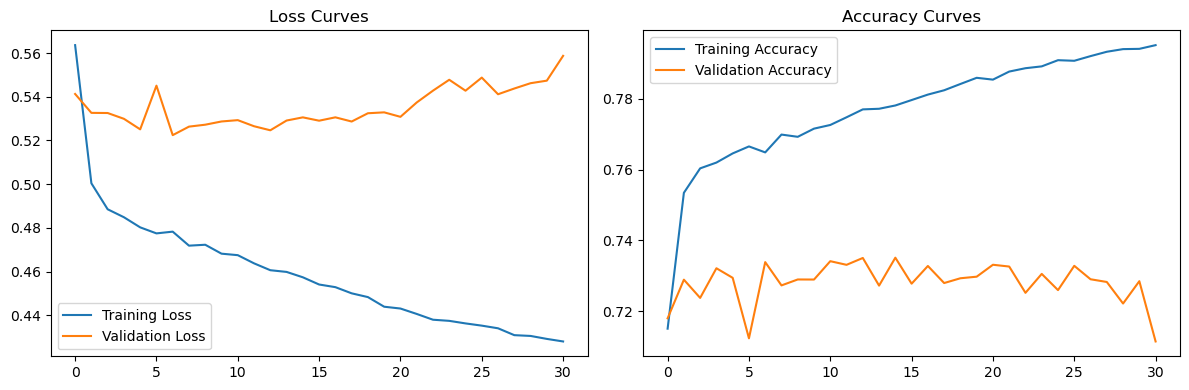

In [13]:
# Build the neural network model
# This creates a multi-input architecture combining user info, numerical features, and text embeddings
model = create_nn_model(
    user_vocab_size = feature_preprocessors["user_vocab_size"],  # Number of unique users
    numerical_feature_size = train_dataset["numerical_input"].shape[1],  # Number of numerical features
    embedding_dim = embedding_dimension,  # Dimension of text embeddings
)

# Display model summary to understand architecture
model.summary()

# Train the model with early stopping on validation loss
print("Training neural network model...")
training_history = train_nn_model(
    model,
    train_dataset, train_labels,
    validation_dataset, validation_labels,
    epochs = 50,  # Maximum number of training epochs
    batch_size = 1024,  # Number of samples per gradient update
)

# Save the trained model
save_nn_model(model, current_run_dir)
print(f"Model saved to {current_run_dir}")

# Plot training history to visualize learning progress
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(training_history.history['loss'], label='Training Loss')
plt.plot(training_history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss Curves')

plt.subplot(1, 2, 2)
plt.plot(training_history.history['accuracy'], label='Training Accuracy')
plt.plot(training_history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy Curves')
plt.tight_layout()
plt.show()

## 8. Evaluate Model on Hold-out Test Data

Now we evaluate our trained model on the hold-out test set. This gives us an unbiased estimate of model performance on new, unseen questions.

In [14]:
# CELL TO UPDATE in main.ipynb (Section 8 Evaluate Model on Hold-out Test Data)

# Load the hold-out test question IDs
holdout_question_ids = pd.read_csv(
    os.path.join(current_run_dir, "holdout_ids.csv")
)[QUESTION_ID_COL].tolist()

# Prepare the test dataset using the same preprocessing transformations
# The `make_dataset` function will now also handle one-hot encoding based on preprocessors
test_dataset, test_labels = make_dataset(
    df = complete_dataset_df,
    q_ids = holdout_question_ids,
    preprocessors = feature_preprocessors, # Contains info about OHE columns and scalers
    combined_embeddings = question_embeddings,
    user_col = USER_ID_COL,
    question_col = QUESTION_ID_COL,
    correctness_col = CORRECTNESS_COL,
    # The following are needed if `preprocessors` doesn't fully define them for test time
    # or if make_dataset reconstructs feature lists.
    # It's safer to pass them if `make_dataset` expects them.
    # Assuming `preprocessors` now contains the 'final_numerical_cols' list.
    # numerical_feature_cols=feature_preprocessors['final_numerical_cols'], # Use the final list
    # categorical_feature_cols_to_encode=CATEGORICAL_FEATURE_COLS_TO_ENCODE
)

# Evaluate the model on the test dataset
print("Evaluating model on hold-out test data...")
test_metrics = evaluate_model(model, test_dataset, test_labels)

# Save the metrics to a JSON file
dump_json(test_metrics, os.path.join(current_run_dir, "holdout_metrics.json"))

# Display the evaluation metrics
print("Test set performance metrics:")
for metric, value in test_metrics.items():
    print(f"  {metric}: {value:.4f}")


Evaluating model on hold-out test data...
Test set performance metrics:
  accuracy: 0.7383
  auc: 0.7585
  precision: 0.7973
  recall: 0.8458
  f1: 0.8208


## 9. Prediction-based IRT Analysis

Finally, we use our trained model to estimate question difficulty parameters and compare them with the original IRT-based estimates. This analysis helps us understand if our neural model captures the same difficulty characteristics as traditional IRT.

The process involves:
1. Generating predictions for all user × question combinations in the test set
2. Using these predictions to fit a new IRT model
3. Comparing the resulting difficulty parameters with the original ones

Generating prediction probability matrix...
Saved prediction probability matrix to /Users/matias/Projects/capstone-new/results/20250506_144443/04_prediction_probabilities.csv
Estimating difficulty parameters from model predictions (2PL)...
Estimating 2PL parameters from binarized predictions...


Training IRT 2PL (PyTorch): 100%|██████████| 200/200 [00:02<00:00, 99.71it/s, loss=0.1524, bce=0.1524] 


Saved predicted 2PL parameters to /Users/matias/Projects/capstone-new/results/20250506_144443/05_predicted_2pl_params.csv
Correlation between original difficulty and predicted discrimination: 0.3581
Correlation between predicted difficulty and predicted discrimination: 0.6780
Difficulty comparison metrics:
  pearson: 0.5846
  spearman: 0.6289
  n: 449.0000


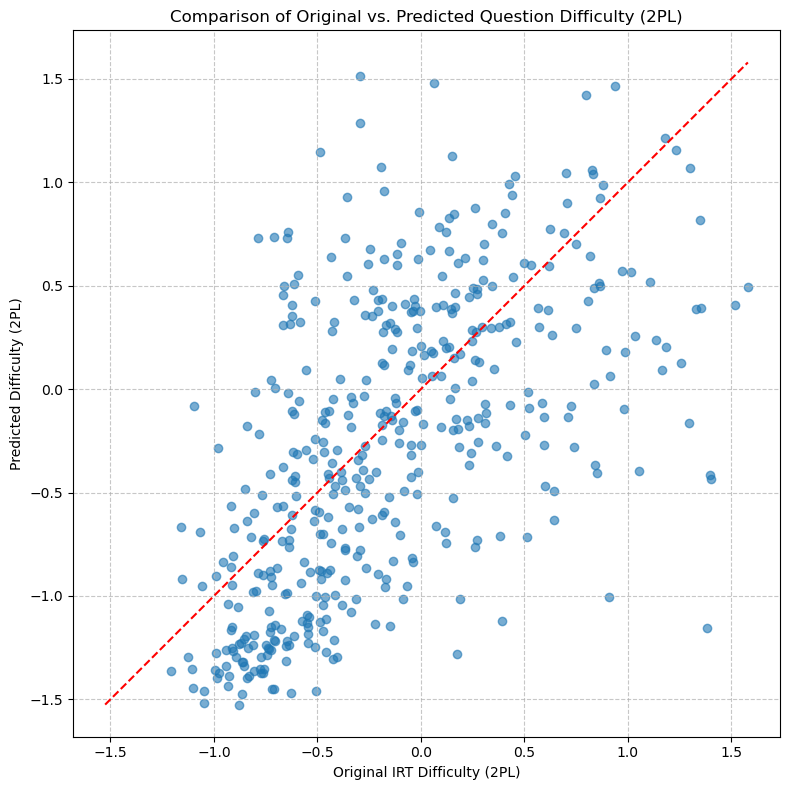

In [15]:
# Generate a probability matrix of predictions
# This contains predicted probabilities for every user × question combination
print("Generating prediction probability matrix...")
probability_matrix = prediction_matrix(
    data_df = complete_dataset_df,
    q_ids = holdout_question_ids,
    preprocessors = feature_preprocessors,
    model = model,
    combined_embeddings = question_embeddings,
    user_col = USER_ID_COL,
    question_col = QUESTION_ID_COL,
)

# Save the probability matrix
probability_matrix_path = os.path.join(current_run_dir, "04_prediction_probabilities.csv")
probability_matrix.to_csv(probability_matrix_path)
print(f"Saved prediction probability matrix to {probability_matrix_path}")

# Fit an IRT model (2PL) to the predicted probabilities to derive new difficulty estimates
print("Estimating difficulty parameters from model predictions (2PL)...")
predicted_params_df = difficulty_from_predictions(probability_matrix) # Returns difficulty & discrimination

# Save the predicted parameters (difficulty and discrimination)
predicted_params_path = os.path.join(current_run_dir, "05_predicted_2pl_params.csv") # New filename
predicted_params_df.to_csv(predicted_params_path, index=False)
print(f"Saved predicted 2PL parameters to {predicted_params_path}")

# Load the original difficulty estimates for comparison
# Make sure this path points to the file saved in *this* run
original_params_df = pd.read_csv(os.path.join(current_run_dir, "01_irt_2pl_params.csv")) # Load original 2PL params

# Compare the original and predicted difficulty parameters
# The compare_difficulty function now handles the _orig/_pred suffixes automatically
difficulty_comparison_metrics = compare_difficulty(original_params_df, predicted_params_df)

# Save the comparison metrics
dump_json(difficulty_comparison_metrics, os.path.join(current_run_dir, "prediction_irt_metrics.json"))

# Display the comparison metrics
print("Difficulty comparison metrics:")
for metric, value in difficulty_comparison_metrics.items():
    print(f"  {metric}: {value:.4f}")

# Create a scatter plot comparing original and predicted difficulties
# Make sure to merge based on the correct column names after suffixes
comparison_df = original_params_df.merge(
    predicted_params_df,
    on=QUESTION_ID_COL,
    suffixes=('_orig', '_pred') # compare_difficulty now handles this merge
)

plt.figure(figsize=(8, 8))
plt.scatter(
    comparison_df[f"{IRT_DIFFICULTY_COL}_orig"], # Use correct suffix _orig
    comparison_df[f"{IRT_DIFFICULTY_COL}_pred"], # Use correct suffix _pred
    alpha=0.6
)
plt.xlabel('Original IRT Difficulty (2PL)') # Updated label
plt.ylabel('Predicted Difficulty (2PL)')  # Updated label
plt.title('Comparison of Original vs. Predicted Question Difficulty (2PL)') # Updated title
plt.grid(True, linestyle='--', alpha=0.7)

# Add a diagonal line representing perfect correlation
# Use correct suffixes _orig and _pred here too
min_val = min(comparison_df[f"{IRT_DIFFICULTY_COL}_orig"].min(), 
              comparison_df[f"{IRT_DIFFICULTY_COL}_pred"].min())
max_val = max(comparison_df[f"{IRT_DIFFICULTY_COL}_orig"].max(), 
              comparison_df[f"{IRT_DIFFICULTY_COL}_pred"].max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--')

plt.tight_layout()
plt.savefig(os.path.join(current_run_dir, "difficulty_comparison_2pl.png"), dpi=300) # New plot filename
plt.show()
